<div style="float:left">
    <h1 style="width:450px">Live Coding 7: NLTK and Friends</h1>
    <h2 style="width:450px">Working with Textual Data!</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Live-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

## Preamble

This practical has been written using `nltk`, but would be _relatively_ easy to rework using `spacy` _except_ that you'd have to first load the requisite models:
```python
import spacy
nlp = spacy.load("en_core_web_sm") # `...web_md` and `...web_lg` are also options
```
You can [read about the models](https://spacy.io/models/en), and note that they are also [available in other languages](https://spacy.io/usage/models).

#### Required Modules

Notice that here we need rather a larger number of modules and functions!

In [1]:
import os
import pandas as pd
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
import nltk
import spacy
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


This next is just a small utility function that allows us to output Markdown (like this cell) instead of plain text:

In [4]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head is not '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

#### Loading and Tidying the Data

Let's only load a subset of the columns--we don't need all 70+ fields, just a few that might be useful for textual analysis:

In [5]:
cols = ['id','listing_url','name','price','description','host_id','host_about','host_listings_count',
        'latitude','longitude','property_type','room_type','accommodates',
        'bathrooms','bathrooms_text','bedrooms','beds','amenities',]
df = pd.read_csv(os.path.join('data','raw','2020-08-24-listings.csv.gz'), usecols=cols, low_memory=False)
df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)

In [6]:
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
print(df.shape)

(74184, 18)


#### Remove NA Values from Text Fields

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: I would be very wary of doing this in a 'proper' application, but to make our lives easier, we're going to drop rows where one of these values is NaN _now_ so it will simplify the steps below. In reality, I would spend quite a bit more time investigating which values are NaN and why before simply dropping them.</div>

Anyway, drop all NaN values:

In [33]:
df.drop(index=df[((df.description.isna())|(df.host_about.isna())|(df.amenities.isna()))].index, inplace=True)
print(df.shape)

(41194, 18)


Notice the scale of that change: according to my queries, we had 74,184 records after dropping rows that were unmappable, but for rows that are missing information about the description, amenities, and host, we've lost nearly half! 

#### Convert to GeoPandas

Read in the Boroughs GeoPackage so that we have a bit more geography here. I'm doing this from GitHub but you could change the URL to be a local file instead if you've already downloaded the file and don't want to download it every time you run this script. We then reproject the InsideAirbnb data to BNG and plot using price as a colormap.

In [34]:
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

In [35]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

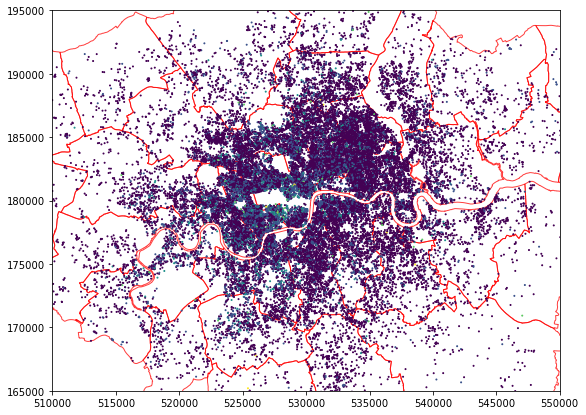

In [36]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
# Why would we use FJ_Sampled here?
gdf.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

## Previewing Textual Data

It's helpful to have a sense of what these data look like before trying to do something with them. You can also change the amount of preview text provided using the pandas options:
```python
print(pd.options.display.max_colwidth) # What's this currently set to?
pd.options.display.max_colwidth=100    # What do we want to set it to?
```

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: In a full text-mining application I would spend a lot more time on this stage: sampling, looking at descriptions in full, performing my analysis (the rest of the steps) and then coming back with a deeper understanding of the data to make further changes to the analysis.</div>

In [37]:
print(pd.options.display.max_colwidth) # What's this currently set to?
pd.options.display.max_colwidth=None   # None = no maximum column width (you probably don't want to leave it at this)

50


#### Description

In [38]:
# Technically, the `isna` is no longer needed, but I left it here for 
# illustrative purposes about how I went about researching what was in
# the data before filtering it out in the cell block up above
gdf[~gdf.description.isna()].description.sample(8, random_state=42)

37453                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         My appartement has independent kitchen and bathroom. It is close to Lewisham train station and DLR station. It’s only 3-minute walk to supermarket and 10-minute walk distance to the shopping centre. You can take buses, trains and DLR to central London.<br /><br /><b>The space</b><br />Gym; Terrace; Study room; Laundry<br /><br /><b>Guest access</b><br />A terrace is available to use.<br /><br /><b>Other things to note</b><br />Please enquire me to check the days of availability and the way of handover

#### About the Host

In [39]:
gdf.host_about.sample(8, random_state=42)

37453                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               I work in the higher education sector.
3518             We are family of artists, filmmakers, business consultants. I've been living across Europe and India for most of my adult life while the rest of my family is based in Kolkata and Mumbai. We love receiving guests ever since i can remember as a little gi

#### Amenities

We don't do anything with this column across the remainder of the notebook, but you'll note that this is a list in the form of a string so you would need to 'deserialise' it using either regular expressions/str.split() _or_ `eval` (more on that [here](https://www.programiz.com/python-programming/methods/built-in/eval)) which is a seriously dangerous method if you don't know what you're doing and/or don't do any checking of the input. To my mind this would be a good candidate for One-Hot encoding after doing a little investigation of the frequency-of-use (_ie_ do you want to dedicate an entire column in an 80k data frame to an amenity that only occurs in 2 listings?).

In [40]:
gdf.amenities.sample(8, random_state=42)

37453                                                                                                                                                                                                                                                                                       ["Private living room", "Elevator", "Hot water", "Gym", "Hair dryer", "Kitchen", "Essentials", "Heating", "Hangers", "Laptop-friendly workspace", "Washer", "Dryer", "Shampoo", "Smoke alarm", "Wifi", "Lock on bedroom door", "Fire extinguisher"]
3518     ["Host greets you", "Paid parking off premises", "Elevator", "Refrigerator", "Children\u2019s books and toys", "Dryer", "Hangers", "Indoor fireplace", "Bed linens", "Iron", "Hot water", "Kitchen", "First aid kit", "Smoke alarm", "Carbon monoxide alarm", "Dishes and silverware", "Cooking basics", "Extra pillows and blankets", "Wifi", "Stove", "Fire extinguisher", "Children\u2019s dinnerware", "Essentials", "Washer", "Oven", "Shampoo", "Hair dryer", "Laptop-fri

## Using Regular Expressions

There is a _lot_ that can be done with Regular Expressions to identify relevant records in textual data and we're going to use this as a starting point for the rest of the analysis. I would normally consider the regexes here a 'first pass' at the data, but would look very carefully at the output of the TF/IDF vectorizer, Count vectorizer, and LDA to see if I could improve my regexes for further cycles of analysis... the main gain there is that regexes are _much_ faster than using the full NLP (Natural Language Processing) pipeline on the _full_ data set each time. As an alternative, you could develop the pipeline using a random subsample of the data and then process the remaining records sequentially -- in this context there is no justification for doing that, but with a larger corpus it might make sense.

#### Luxury Accommodation

I would encourage you to consider what other words might help to signal 'luxury'... perhaps words like 'stunning' or 'prestigious'? Could you add those to the regex?

In [41]:
gdf[gdf.description.str.contains(r'luxur(?:y|ious)', regex=True, flags=re.IGNORECASE)].description.sample(15, random_state=42)

70180                                                                                                                                                                                Located in a serene and upscale part of North-West London is this  Stylish and Luxuriously furnished three bedroom three bathroom semi-detached house.<br /><br />The first thought that comes to mind as you step through the front door is luxury. This property is newly refurbished to an exceptional high standard and can comfortably sleep 6 persons.<br /><br /><b>The space</b><br />This gorgeous and spacious home spread over two floors boasts of three double bedrooms with two en-suite bathrooms, family bathroom / toilet and a guest toilet. <br /><br />There are two living rooms with one of the living rooms having a dining section and open plan kitchen. The dining section opens up to a large garden ideal for a family choosing to relax for the evening or having a barbecue. The property comes with two front parkin

Assign it to a new data frame called `lux`:

In [42]:
lux = gdf[gdf.description.str.contains(r'luxur(?:y|ious)', regex=True, flags=re.IGNORECASE)].copy()
print(lux.shape)

(3203, 19)


And plot:

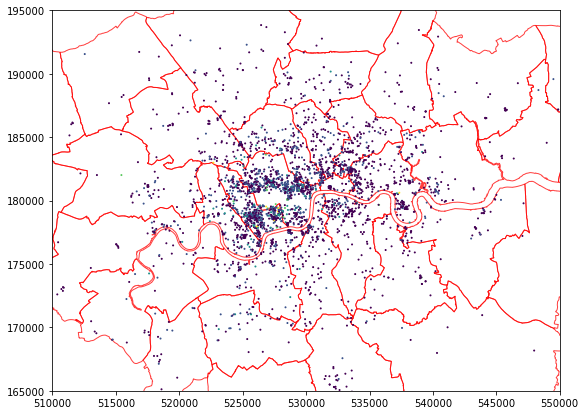

In [43]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
ax = lux.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

#### Budget Accommodation

What words can you think of that might help you to spot affordable and budget accommodation? Start with just a couple of words and then I would encourage you to consider what _other_ words might help to signal 'affordability'... perhaps words like 'cosy' or 'charming' and then think about how you could you add those to the regex?

In [44]:
gdf[gdf.description.str.contains(r'(?:budget|cheap|compact|co(?:z|s)y)', regex=True, flags=re.IGNORECASE)].description.sample(15, random_state=42)

2474     Do you need a temporary base in London or fancy some quiet time from your typical lifestyle? This private (you do not share any of it during your stay), airy-yet-cosy studio space in Catford - with 12' ceilings and 9' windows - is a city-lover's home-away-from-home. It comes with an enormous garden, ample free parking and a short walk to the town centre where there are two train stations - in addition to banks, restaurants and more - that take you to the heart of London within 20 to 30 minutes.<br /><br /><b>The space</b><br />*** The space is cleaned and tidied between each reservation by a professional cleaner who follows COVID-19 cleanliness guidelines  *** <br /><br />*About: duration of stay*<br /><br />I'm ideally looking for guests for a period between one and three months at a time to act as my lodger/home-guardian. This is ideal for a tourist, London-job-hunter, temporary worker/course-attender or recent transplant; someone who needs to move or travel to London and re

In [46]:
aff = gdf[gdf.description.str.contains(r'(?:budget|cheap|compact|co(?:z|s)y)', regex=True, flags=re.IGNORECASE)].copy()
print(aff.shape)

(6426, 19)


In [ ]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
ax = aff.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

#### Near Greenspace

Now see if you can work out a regular expression to find accommodation that emphasises accessibility to greenspace as part of the description? One thing you'll need to tackle is that many listings seem to say something about _parking_ and you wouldn't want those be returned as part of a regex looking for _parks_.

In [ ]:
print(pd.options.display.max_colwidth)
pd.options.display.max_colwidth=100
gdf[gdf.description.str.contains(r'\bparks?\b', regex=True, flags=re.IGNORECASE)].description.sample(15, random_state=42)pd.options.display.max_colwidth=30

In [ ]:
green = gdf[gdf.description.str.contains(r'\bparks?\b', regex=True, flags=re.IGNORECASE)].copy()
print(green.shape)

In [ ]:
parks = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Greenspace.gpkg?raw=true')

In [ ]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
parks.plot(edgecolor='none', facecolor=(0.4, 0.8, 0.4, 0.75), ax=ax)
green.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

## Illustrative Text Cleaning

Now we're going to step through the _parts_ of the process that we apply to clean and transform text. We'll do this individually before using a function to apply them _all at once_.

In [9]:
import urllib
url = 'https://www.ucl.ac.uk/bartlett/casa/about'
with urllib.request.urlopen(url) as response:
   the_html = response.read()

In [10]:
the_html[:250]

b'<!DOCTYPE html>\n<!--[if IE 7]>\n<html lang="en" class="lt-ie9 lt-ie8 no-js"> <![endif]-->\n<!--[if IE 8]>\n<html lang="en" class="lt-ie9 no-js"> <![endif]-->\n<!--[if gt IE 8]><!-->\n<html lang="en" class="no-js"> <!--<![endif]-->\n<head>\n  <meta name="vie'

### Lower Case

We also do some basic filtering on empty lines and I'm going to cheat a little by extracting only the 'About Us' section of the document (you would use BS4 to do this normally):

In [12]:
lower = [x.lower() for x in the_html.decode("utf-8").split("\n") if not re.match("^\s*$", x)]

In [13]:
for l in lower[183:186]:
    as_markdown("Content", l)

##### Content

>    <img height="347" width="768" class="large-image" alt="casa about us" typeof="foaf:image" src="https://www.ucl.ac.uk/bartlett/casa/sites/bartlett/files/styles/large_image/public/48641707292_e1272cb7ed_o.jpg?itok=gyp-pbom" /></div>


##### Content

></div>


##### Content

></div>casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation.<p>we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live.</p><p>based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities.</p><p>casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities.</p><h2 class="heading">our vision</h2><p>casa's focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base, drawing on cutting edge methods, and ideas in modeling, complexity, visualisation and computation.</p><p>our current mix of geographers, mathematicians, physicists, architects and computer scientists make casa a unique institute within ucl.</p><p>our vision is to be central to this new science, the science of smart cities, and relate it to city planning, policy and architecture in its widest sense.</p><p>the focus is on advancing the state of the art through research complemented by graduate study, teaching, consultancy and distance learning.</p><h2 class="heading">facilities</h2><p>casa is located at 90 tottenham court road in london where all of our research is conducted. our research groups are seated in close proximity to each other in an open plan office, where we also accommodate our phd students. </p>    


### Removing HTML

In [14]:
cleaned = []
for l in lower[183:186]:
    # What is this regex doing? Maybe 'view source' the URL?
    tmp = re.sub(r'(\/[A-Za-z]+\d?|[A-Za-z]+ \/)>','\\1> ', l)
    soup = BeautifulSoup(tmp, "html.parser")
    # What is going on here?
    # deleting /h2, /p, <br />
    if not re.match(r'^\s*$',soup.get_text()):
        cleaned.append(soup.get_text())

In [15]:
for c in cleaned:
    as_markdown("Listing", c)

##### Listing

> casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation.we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live. based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities. casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities. our vision casa's focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base, drawing on cutting edge methods, and ideas in modeling, complexity, visualisation and computation. our current mix of geographers, mathematicians, physicists, architects and computer scientists make casa a unique institute within ucl. our vision is to be central to this new science, the science of smart cities, and relate it to city planning, policy and architecture in its widest sense. the focus is on advancing the state of the art through research complemented by graduate study, teaching, consultancy and distance learning. facilities casa is located at 90 tottenham court road in london where all of our research is conducted. our research groups are seated in close proximity to each other in an open plan office, where we also accommodate our phd students.  


### Punctuation

We want to clear out punctuation using a regex that takes advantage of the `[...]` syntax:

In [20]:
pattern = re.compile(r'[\.\,\-\–;:\'\"]')
punkt   = []
for c in cleaned:
    punkt.append(re.sub(pattern, ' ', c))

In [22]:
for p in punkt:
    as_markdown("Listing", p)

##### Listing

> casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling  sensing the urban environment  visualisation and computation we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities  our vision is to play a central role in the science of smart cities   applying it to city planning  policy and architecture in the pursuit of making our cities better places to live  based in bloomsbury  london  casa is our living laboratory  as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities  casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines  all with a common domain knowledge in cities  our vision casa s focus is to be at the forefront of what is one of the grand challenges of 21st century science  to build a science of cities from a multidisciplinary base  drawing on cutting edge methods  and ideas in modeling  complexity  visualisation and computation  our current mix of geographers  mathematicians  physicists  architects and computer scientists make casa a unique institute within ucl  our vision is to be central to this new science  the science of smart cities  and relate it to city planning  policy and architecture in its widest sense  the focus is on advancing the state of the art through research complemented by graduate study  teaching  consultancy and distance learning  facilities casa is located at 90 tottenham court road in london where all of our research is conducted  our research groups are seated in close proximity to each other in an open plan office  where we also accommodate our phd students   


### Stopword Removal

In [23]:
from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))
stopped = []
for p in punkt:
    stopped.append(' '.join([x for x in re.split(r'\s+', p) if x not in stopword_list]))

In [24]:
for s in stopped:
    as_markdown("Listing", s)

##### Listing

> casa established 1995 lead development science cities drawing upon methods ideas modelling sensing urban environment visualisation computation seek examine offer solutions problems resource efficiency effective planning governance shared cities vision play central role science smart cities applying city planning policy architecture pursuit making cities better places live based bloomsbury london casa living laboratory one world’s truly global metropolises nowhere ideal london learning challenges confronting modern cities casa established concentration academics wide breadth expertise range disciplines common domain knowledge cities vision casa focus forefront one grand challenges 21st century science build science cities multidisciplinary base drawing cutting edge methods ideas modeling complexity visualisation computation current mix geographers mathematicians physicists architects computer scientists make casa unique institute within ucl vision central new science science smart cities relate city planning policy architecture widest sense focus advancing state art research complemented graduate study teaching consultancy distance learning facilities casa located 90 tottenham court road london research conducted research groups seated close proximity open plan office also accommodate phd students 


### Lemmatisation vs Stemming

In [25]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

In [26]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('monkeys'))
print(lemmatizer.lemmatize('cities'))
print(lemmatizer.lemmatize('complexity'))
print(lemmatizer.lemmatize('Reades'))

monkey
city
complexity
Reades


In [32]:
stemmer = PorterStemmer()
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read


In [28]:
stemmer = SnowballStemmer(language='english')
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read


In [29]:
lemmatizer = WordNetLemmatizer()
lemmas = []
for s in stopped:
    lemmas.append(' '.join([lemmatizer.lemmatize(x) for x in s.split(' ')]))

In [30]:
for l in lemmas:
    as_markdown('Listing',l)

##### Listing

> casa established 1995 lead development science city drawing upon method idea modelling sensing urban environment visualisation computation seek examine offer solution problem resource efficiency effective planning governance shared city vision play central role science smart city applying city planning policy architecture pursuit making city better place live based bloomsbury london casa living laboratory one world’s truly global metropolis nowhere ideal london learning challenge confronting modern city casa established concentration academic wide breadth expertise range discipline common domain knowledge city vision casa focus forefront one grand challenge 21st century science build science city multidisciplinary base drawing cutting edge method idea modeling complexity visualisation computation current mix geographer mathematician physicist architect computer scientist make casa unique institute within ucl vision central new science science smart city relate city planning policy architecture widest sense focus advancing state art research complemented graduate study teaching consultancy distance learning facility casa located 90 tottenham court road london research conducted research group seated close proximity open plan office also accommodate phd student 


## Applying Normalisation

The above approach is fairly hard going since you need to loop through every list element applying these changes one at a time. Instead, we can use pandas `apply` method together with some code built on top of work by others to simplify this process even though it will still be processor-intensive.

#### Downloading the Custom Module

You will need to download _and_ unzip [this file](https://github.com/jreades/i2p/blob/master/practicals/textual.zip?raw=true) into the directory where this notebook is running (since the `import` will look for a directory named `textual` wherever this code is running. The custom module is not perfect, but it gets the job done... mostly.

#### Importing the Custom Module

Now let's import it.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from textual import *

In [ ]:
as_markdown('Normalised', normalise_document(??))

## Revenons à Nos Moutons

Now that you've seen how the steps are applied to a 'random' HTML document, let's get back to the problem at hand (revenons à nos moutons == let's get back to our sheep).

In [ ]:
lux['description_norm'] = lux.description.??(??)

In [ ]:
aff['description_norm'] = aff.description.??(??)

In [ ]:
green['description_norm'] = green.description.??(??)

#### Full File

<div style="border: dotted 1px red; padding: 10px; margin: 5px; background-color: rgb(255,249,249);"><i>Warning</i>: This code can take <i>some time</i> to run, so <b>don't run this now</b> as we're just going to work with the subsets!</div>


You will get a warning about `"." looks like a filename, not markup` -- this looks a little scary, but is basically suggesting that we have a description that consists only of a '.'. 

In [ ]:
gdf['description_norm'] = ''
gdf['description_norm'] = gdf.description.apply(normalise_document)

In [ ]:
gdf.to_file(os.path.join('data','raw','2020-08-24-listings-with-nlp-subset.gpkg'))

## Feature Extraction

See useful tutorial [here](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275). Although we shouldn't have any empty descriptions, by the time we've finished normalising the textual data we may have _created_ some empty values and we need to ensure that we don't accidentally pass a NaN to the vectorisers and frequency distribution functions.

In [ ]:
corpus = lux.description_norm.fillna(' ').values

In [ ]:
print(corpus[0:2])

#### Frequency Distributions

Regular expressions _again_! See, we use them all over the place. See if you can expand the regex to suppress all punctuation _and_ numbers. This is a metacharacter problem.

One new thing you'll see here is the `ngram`: ngrams are 'simply' pairs, or triplets, or quadruplets of words. You may come across the terms unigram (`ngram(1,1)`), bigram (`ngram(2,2)`), trigram (`ngram(3,3)`)... typically, you will rarely find anything beyond trigrams, and these present real issues for text2vec algorithms because the embedding for `geographical`, `information`, and `systems` is _not_ the same as for `geographical information systetms`.

In [ ]:
data = [x for x in ' '.join(corpus).split() if not re.match(r'[,.\-\(\)!\&0-9\;\:]', x)]

fcounts = dict()

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one, note this: https://stackoverflow.com/questions/15145172/nltk-conditionalfreqdist-to-pandas-dataframe
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

In [ ]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))

#### Count Vectoriser

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,3))
vectorizer.fit(??)

Note all of the methods available to interrogate the transformer:

In [ ]:
dir(vectorizer)

Find the number associated with a word in the vocabulary:

In [ ]:
# Find the vocabulary mapping
print(vectorizer.vocabulary_['stratford'])

How many times does it occur in the original corpus:

In [ ]:
lux.description_norm.str.contains('stratford').sum()

Note the type of the transformed corpus:

In [ ]:
tcorpus = vectorizer.transform(corpus)
tcorpus # tcorpus for transformed corpus

Here is the first document from the corpus:

In [ ]:
lux.description_norm.iloc[0]

In [ ]:
doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Counts"])
doc_df.sort_values('Counts', ascending=False).head(10)

In [ ]:
cvdf = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())

In [ ]:
cvdf.head()

Column sums:

In [ ]:
sums = cvdf.sum()
sums.head()

Remove columns (i.e. terms) appearing in less than 5% of documents. You can do this by thinking about what the shape of the data frame means (rows and/or columns) and how you'd get 5% of that!

In [ ]:
filter = sums >= cvdf.?? * ??

We'll come back to this soon:

In [ ]:
cvdf.drop(columns=cv_df.columns[~filter].values, inplace=True)
cvdf.head()

#### TF/IDF Vectoriser

Notice that you can have `max` and `min` frequencies here. I've opted for 50% and 5% but you can pick other values

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), max_df=0.5, min_df=0.05)
tcorpus    = vectorizer.fit_transform(corpus)

In [ ]:
doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Weights"])
doc_df.sort_values('Weights', ascending=False).head(10)

In [ ]:
tfidf = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())
tfidf.head()

## Word Clouds

#### For Counts

In [ ]:
cvdf.sum().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(cvdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

#### For TF/IDF Weighted Words

In [ ]:
tfidf.sum().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(tfidf.??())
plt.imshow(Cloud) 
plt.axis("off");

## Latent Dirchlet Allocation

Adapted from [this post](https://stackabuse.com/python-for-nlp-topic-modeling/) on doing LDA using sklearn. Most other examples use the `gensim` library, which isn't installed in the Docker image that I provided. You could install it on the command line (the _Jupyter_ command line!) but it will be lost every time you restart the server.

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2)) # Notice change to ngram range (try 1,1 and 1,2 for other options)

In [ ]:
vectorizer.fit(??) 
tcorpus = vectorizer.transform(??) # tcorpus for transformed corpus

LDA = LatentDirichletAllocation(n_components=10, random_state=42) # Might want to experiment with n_components too
LDA.fit(tcorpus)

In [ ]:
first_topic = LDA.components_[0]
top_words = first_topic.argsort()[-25:]

for i in top_words:
    print(vectorizer.get_feature_names()[i])

In [ ]:
for i,topic in enumerate(LDA.components_):
    as_markdown(f'Top 10 words for topic #{i}', ', '.join([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]]))

#### Maximum Likelihood Topic

In [ ]:
tdf = lux # Saves having to change the variable name below for aff, green, etc.

In [ ]:
topic_values = LDA.transform(tcorpus)
topic_values.shape

In [ ]:
pd.options.display.max_colwidth=20
tdf['Topic'] = topic_values.argmax(axis=1)
tdf.head()

In [ ]:
pd.options.display.max_colwidth=75
tdf[tdf.Topic==1].description.head(10)

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(tdf[tdf.Topic==1].description.values) # tcorpus for transformed corpus

In [ ]:
topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names())

In [ ]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

## Applications



The above is _still_ only the results for the 'luxury' apartments _alone_. At this point, you would probably want to think about how your results might change if you changed any of the following:

1. Using one of the other data sets that we created, or even the entire data set!
2. Applying the CountVectorizer or TfidfVectorizer _before_ selecting out any of our 'sub' data sets.
3. Using the visualisation of information from \#2 to improve our regex selection process.
4. Reducing, increasing, or constraining (i.e. `ngrams=(2,2)`) the size of the ngrams while bearing in mind the impact on processing time and interpretability.
5. Filtering by type of listing or host instead of keywords found in the description (for instance, what if you applied TF/IDF to the entire data set and then selected out 'Whole Properties' before splitting into those advertised by hosts with only one listing vs. those with multiple listings?).
6. Linking this back to the geography.

Over the next few weeks we'll also consider alternative means of visualising the data!

## Resources

There is a lot more information out there, including a [whole book](https://www.nltk.org/book/) and your standard [O'Reilly text](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).

And some more useful links:
- [Pandas String Contains Method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)
- [Using Regular Expressions with Pandas](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)
- [Summarising Chapters from Frankenstein using TF/IDF](https://towardsdatascience.com/using-tf-idf-to-form-descriptive-chapter-summaries-via-keyword-extraction-4e6fd857d190)